In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-australia/weatherAUS.csv


# NAIVE BEFORE FEATURE SELECTION


Data Preprocessing Completed ✅ - Saved as 'cleaned_weather_data.csv'
Naive Bayes Before Feature Selection
Optimized Naïve Bayes Accuracy: 0.7659
Precision: 0.7588
Recall: 0.7615
F1 Score: 0.7602
ROC AUC: 0.8423
G-Mean: 0.7658


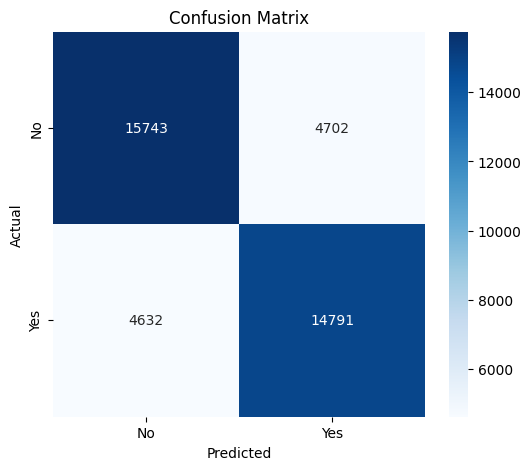

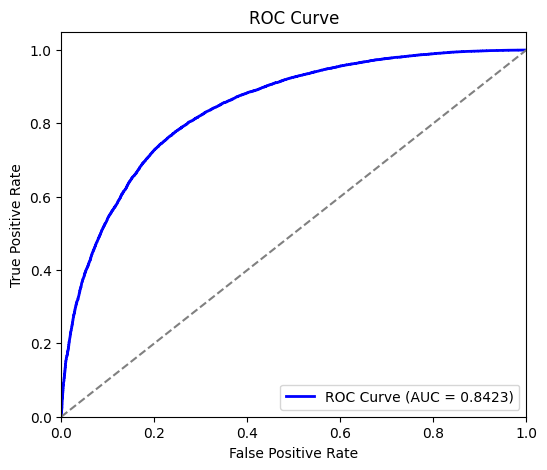

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
data = pd.read_csv(file_path)

# Handling Missing Values
num_imputer = SimpleImputer(strategy="mean")  # For numerical columns
cat_imputer = SimpleImputer(strategy="most_frequent")  # For categorical columns

num_cols = data.select_dtypes(include=[np.number]).columns
data[num_cols] = num_imputer.fit_transform(data[num_cols])
cat_cols = data.select_dtypes(include=["object"]).columns
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Encoding Categorical Variables
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Save cleaned dataset
cleaned_file = "cleaned_weather_data.csv"
data.to_csv(cleaned_file, index=False)
print(f"\nData Preprocessing Completed ✅ - Saved as '{cleaned_file}'")

# Define features and target
X = data.drop(['RainTomorrow'], axis=1)
y = data['RainTomorrow']

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.95, random_state=42, k_neighbors=4)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data with optimized stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.18, stratify=y_resampled, random_state=42)

# Feature Scaling using MinMaxScaler and QuantileTransformer
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

qt = QuantileTransformer(output_distribution='normal')
X_train_scaled = qt.fit_transform(X_train_scaled)
X_test_scaled = qt.transform(X_test_scaled)

# Optimized Naïve Bayes model with tuned var_smoothing
nb = GaussianNB(var_smoothing=1e-8)
nb.fit(X_train_scaled, y_train)

# Make predictions and evaluate
y_pred = nb.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, nb.predict_proba(X_test_scaled)[:, 1])
g_mean = geometric_mean_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Naive Bayes Before Feature Selection")
print(f"Optimized Naïve Bayes Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"G-Mean: {g_mean:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, nb.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


# NAIVE BAYES AFTER FEATURE SELECTION


Data Preprocessing Completed ✅ - Saved as 'cleaned_weather_data.csv'
Selected Features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday']
Best parameters found: {'priors': None, 'var_smoothing': 1e-09}
Naive Bayes after Feature Selection
Optimized Naïve Bayes Accuracy: 0.7503
Precision: 0.7787
Recall: 0.6992
F1 Score: 0.7368
ROC AUC: 0.8289
G-Mean: 0.7485


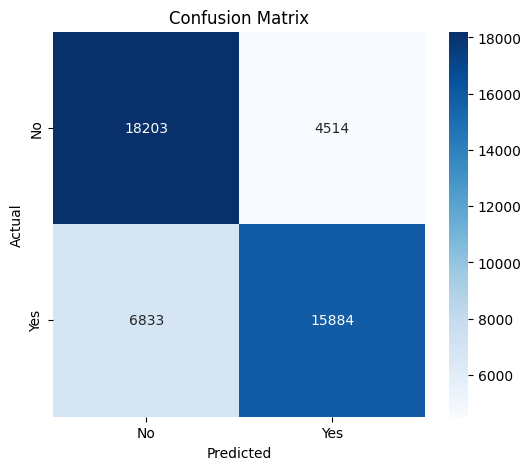

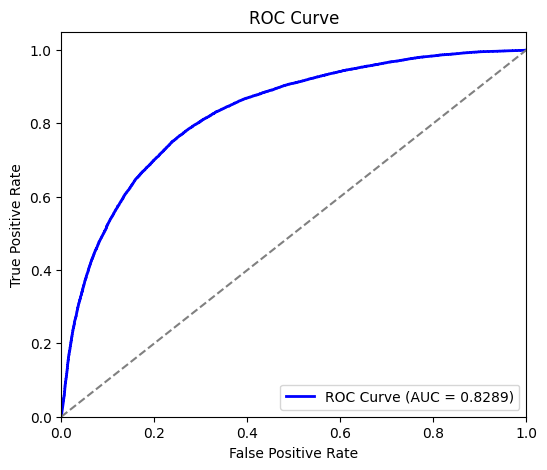

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
file_path = "/kaggle/input/weather-australia/weatherAUS.csv"
data = pd.read_csv(file_path)

# Handling Missing Values
num_imputer = SimpleImputer(strategy="mean")  # For numerical columns
cat_imputer = SimpleImputer(strategy="most_frequent")  # For categorical columns

num_cols = data.select_dtypes(include=[np.number]).columns
data[num_cols] = num_imputer.fit_transform(data[num_cols])
cat_cols = data.select_dtypes(include=["object"]).columns
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Encoding Categorical Variables
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Save cleaned dataset
cleaned_file = "cleaned_weather_data.csv"
data.to_csv(cleaned_file, index=False)
print(f"\nData Preprocessing Completed ✅ - Saved as '{cleaned_file}'")

# Define features and target
X = data.drop(['RainTomorrow'], axis=1)
y = data['RainTomorrow']

# Feature Selection using SelectKBest
k = 16 # Select top 16 features to improve performance
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print(f"Selected Features: {list(selected_features)}")

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Naïve Bayes model
nb = GaussianNB()

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'priors': [None, [0.65, 0.35], [0.7, 0.3]],  # Adjusted priors for better precision
    'var_smoothing': [1e-9, 5e-9, 1e-8]  # Fine-tuned smoothing values
}

grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='f1')  # Optimizing for F1-score
grid_search.fit(X_train_scaled, y_train)

# Best parameters from grid search
print("Best parameters found:", grid_search.best_params_)

# Train the best model
best_nb = grid_search.best_estimator_

# Make predictions and evaluate
y_pred = best_nb.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_nb.predict_proba(X_test_scaled)[:, 1])
g_mean = geometric_mean_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Naive Bayes after Feature Selection")
print(f"Optimized Naïve Bayes Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"G-Mean: {g_mean:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_nb.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
